In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(
            os.path.join(dirname, filename)#)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-04-15 16:17:02.394718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 16:17:02.394822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 16:17:02.539658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Data

In [3]:
filepath = "../input/plantdisease/PlantVillage/"
random_seed = 101
categories = os.listdir(filepath)

# Printing all the class labels and Number of categories

In [4]:
print("Class labels: {}\n\nNumber of categories: {}".format(categories, len(categories)))

Class labels: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']

Number of categories: 15


# Data Exploring

In [5]:
def load_images_and_labels(categories, filepath, max_images_per_category=300, target_size=(227, 227)):
    img_lst = []
    labels = []
    for index, category in enumerate(categories):
        category_path = os.path.join(filepath, category)
        if not os.path.isdir(category_path):
            continue
        count = 0
        for image_name in os.listdir(category_path):
            if count >= max_images_per_category:
                break
            file_ext = image_name.split(".")[-1].lower()
            if file_ext in ["jpg", "jpeg"]:
                image_path = os.path.join(category_path, image_name)
                try:
                    img = cv2.imread(image_path)
                    if img is None:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_array = Image.fromarray(img, 'RGB')
                    resized_img = img_array.resize(target_size)
                    img_lst.append(np.array(resized_img))
                    labels.append(index)
                    count += 1
                except Exception as e:
                    print(f"Error processing image: {image_path} - {e}")
    return img_lst, labels

images, labels = load_images_and_labels(categories, filepath)
print("Number of images loaded:", len(images))
print("Number of labels loaded:", len(labels))
print("Data types:", type(images), type(labels))

Number of images loaded: 4352
Number of labels loaded: 4352
Data types: <class 'list'> <class 'list'>


In [6]:
images = np.array(images)
labels = np.array(labels)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

print("Data types:", type(images), type(labels))

Images shape: (4352, 227, 227, 3)
Labels shape: (4352,)
Data types: <class 'numpy.ndarray'> <class 'numpy.ndarray'>


# Method to Display random images with labels from the dataset

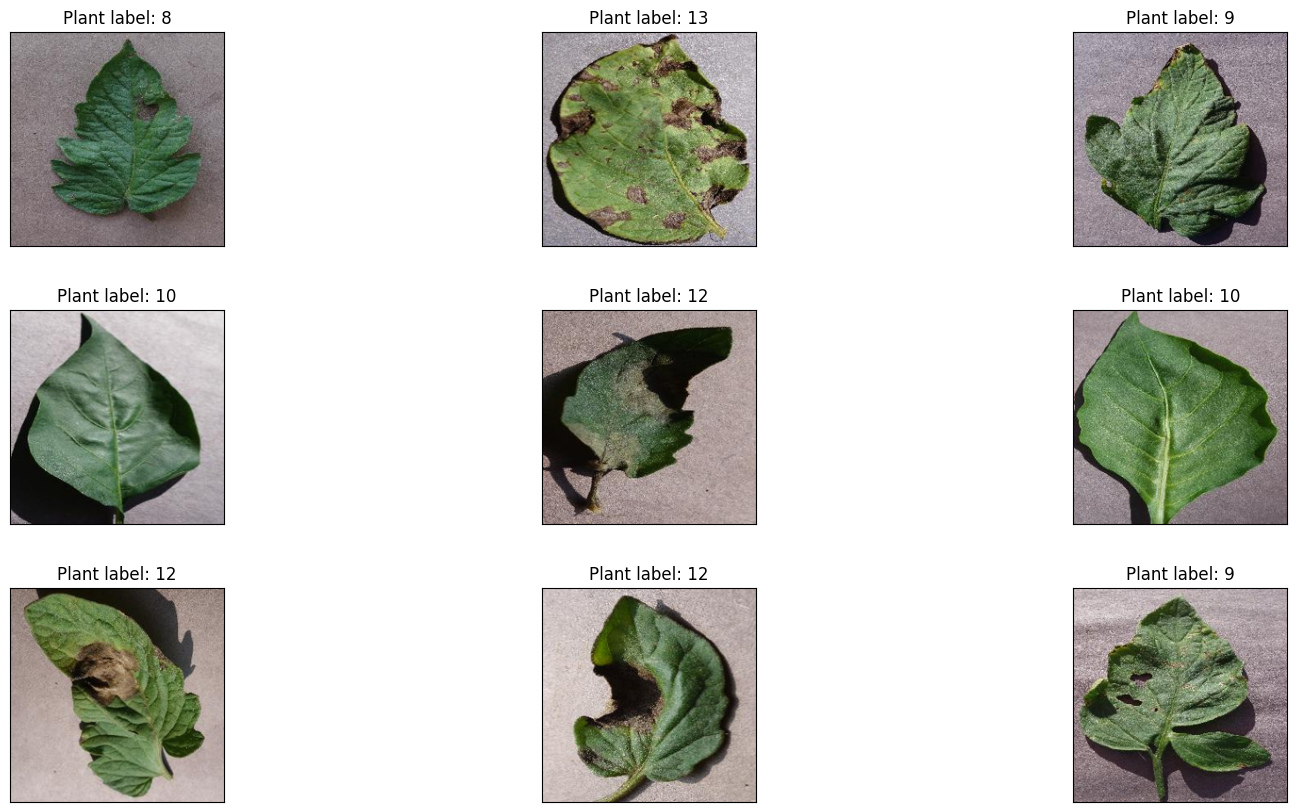

In [7]:
def display_random_images_with_labels(images, labels, num_rows=3, num_cols=3):
    plt.figure(figsize=(19, 10))
    for i, _ in enumerate(range(num_rows * num_cols)):
        r = np.random.randint(0, images.shape[0])
        
        plt.subplot(num_rows, num_cols, i + 1)
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        plt.imshow(images[r])
        
        plt.title('Plant label: {}'.format(labels[r]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

display_random_images_with_labels(images, labels)

## Mixing up the data to train the CNN

In [8]:
# Step 1: Shuffle the indices for data shuffling

indices = np.arange(images.shape[0])
print("Indices before shuffling:", indices)

np.random.seed(random_seed)
np.random.shuffle(indices)
print("Indices after shuffling:", indices)

Indices before shuffling: [   0    1    2 ... 4349 4350 4351]
Indices after shuffling: [3591 1775 3666 ...  599 1361 1547]


In [9]:
# Step 2: Shuffle the images and corresponding labels

images = images[indices]
labels = labels[indices]

print("Images shape after shuffling:", images.shape)
print("Labels shape after shuffling:", labels.shape)

Images shape after shuffling: (4352, 227, 227, 3)
Labels shape after shuffling: (4352,)


## Normalizing the loaded Data

In [10]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)

# Normalize the images to range [0, 1]
images /= 255.0

print("Images shape after normalization:", images.shape)

Images shape after normalization: (4352, 227, 227, 3)


# Display random images with labels after Normalizing the data

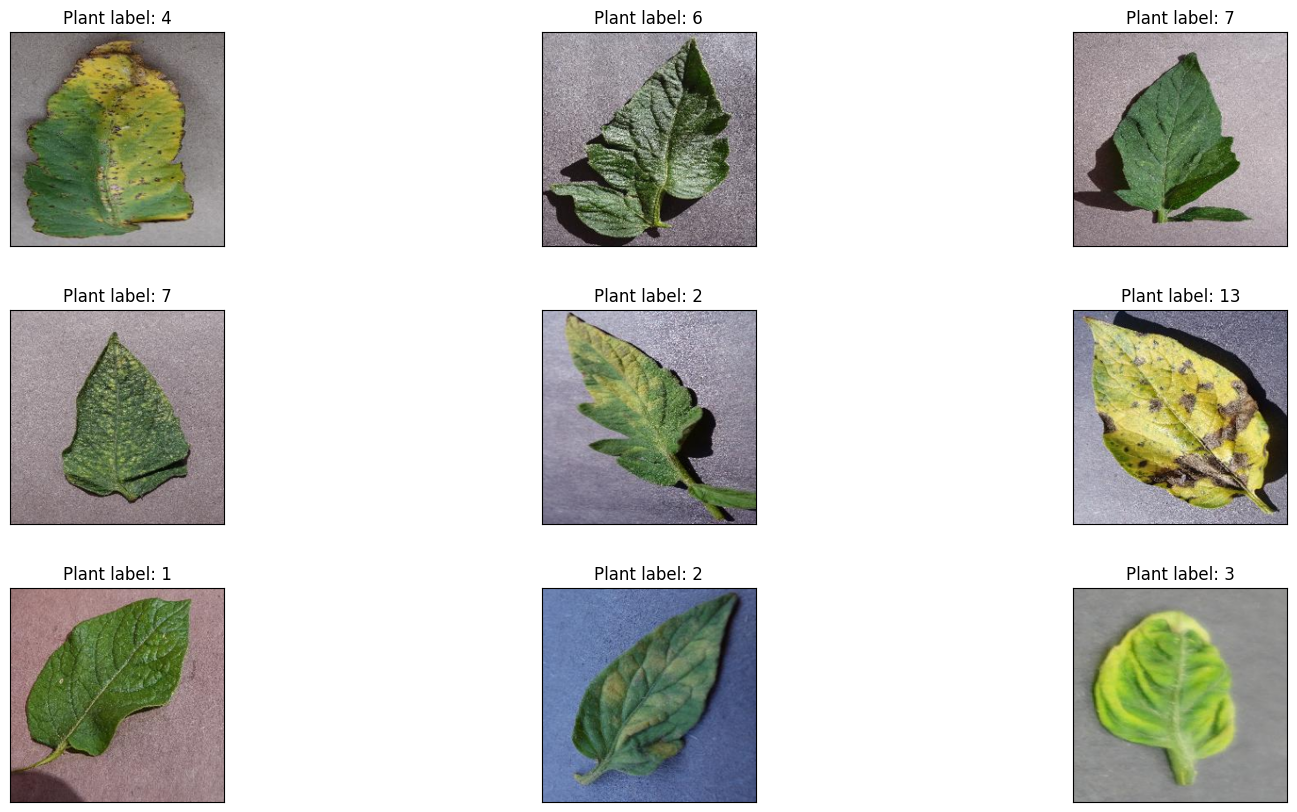

In [11]:
display_random_images_with_labels(images, labels)

# Spliting the dataset for training and testing

In [12]:
def train_test_val_split(data, labels, test_size=0.2, val_size=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle indices
    indices = np.arange(len(data))
    np.random.shuffle(indices)

    # Calculate split indices
    test_index = int(len(data) * (1 - test_size))
    val_index = int(test_index - len(data) * val_size)

    # Split data
    train_indices = indices[:val_index]
    val_indices = indices[val_index:test_index]
    test_indices = indices[test_index:]

    X_train, y_train = data[train_indices], labels[train_indices]
    X_val, y_val = data[val_indices], labels[val_indices]
    X_test, y_test = data[test_indices], labels[test_indices]

    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the data into training, validation, and test sets
x_train, x_val, x_test, y_train, y_val, y_test = train_test_val_split(images, labels, test_size=0.2, val_size=0.1, random_state=random_seed)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (3045, 227, 227, 3)
y_train shape: (3045,)
x_val shape: (436, 227, 227, 3)
y_val shape: (436,)
x_test shape: (871, 227, 227, 3)
y_test shape: (871,)


# Display random images with labels from the training data

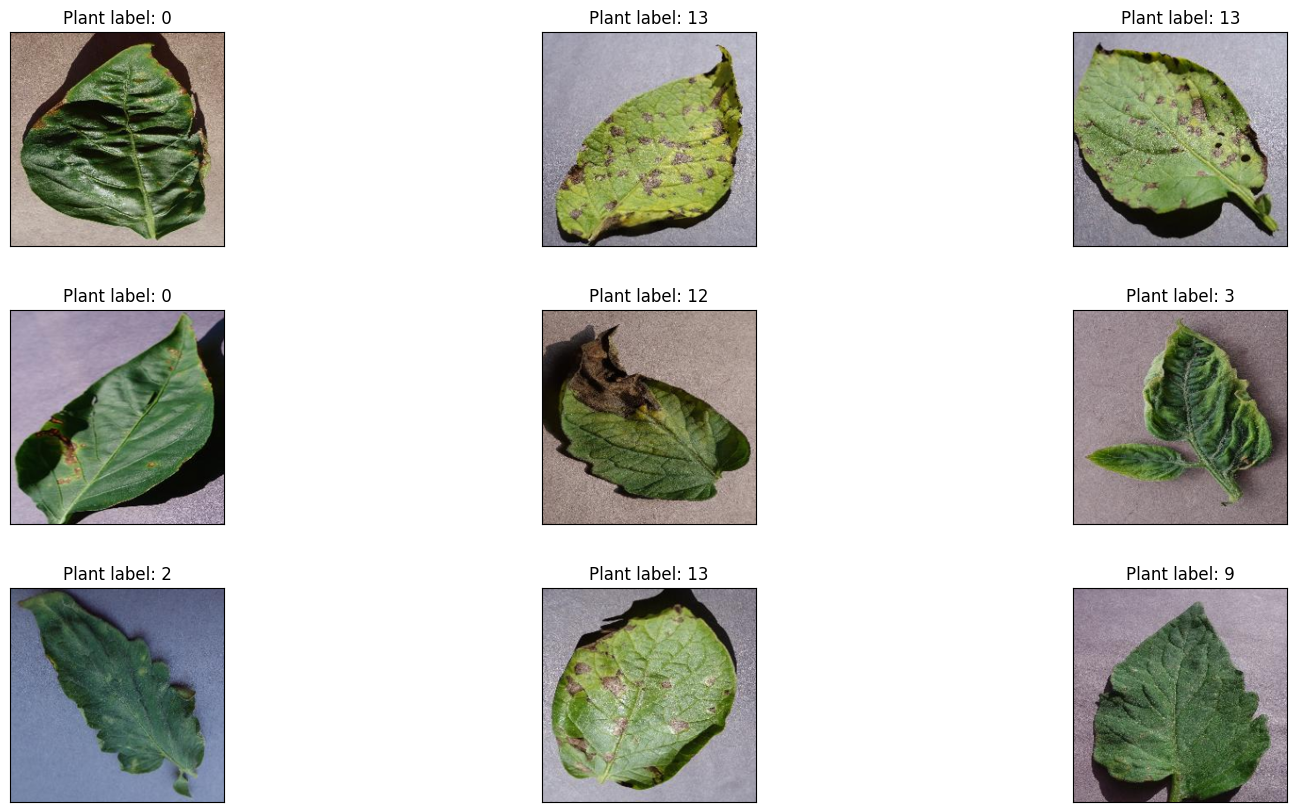

In [13]:
display_random_images_with_labels(x_train, y_train)

## CNN model

In [14]:
def add_conv_pool_layers(model, filters, kernel_size, strides, input_shape=None, pool_size=(3, 3), padding="valid", activation="relu"):
    if input_shape:
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation, input_shape=input_shape, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    else:
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
    model.add(BatchNormalization())

def add_dense_layers(model, units, input_shape=None, activation="relu", dropout_rate=0.4):
    if input_shape:
        model.add(Dense(units=units, input_shape=input_shape, activation=activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    else:
        model.add(Dense(units=units, activation=activation, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

model = Sequential()

add_conv_pool_layers(model, filters=96, kernel_size=(11, 11), strides=(4, 4), input_shape=(227,227,3))
add_conv_pool_layers(model, filters=256, kernel_size=(5, 5), strides=(1, 1))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="valid", activation="relu"))
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())

add_dense_layers(model, units=4096, input_shape=(227,227,3))
add_dense_layers(model, units=4096)
add_dense_layers(model, units=1000)

model.add(Dense(units=20, activation="softmax"))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 27, 27, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │        20,02

 Total params: 28,883,132 (110.18 MB)

 Trainable params: 28,863,532 (110.11 MB)

 Non-trainable params: 19,600 (76.56 KB)

## Compiling the CNN model

In [15]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Early stopping callback

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the Model with the Training Data

In [17]:
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/500
 5/96 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0790 - loss: 78.2357

I0000 00:00:1713197898.723711      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - accuracy: 0.1804 - loss: 67.7497 - val_accuracy: 0.1055 - val_loss: 28.4984
Epoch 2/500


W0000 00:00:1713197918.616730      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3072 - loss: 21.1605 - val_accuracy: 0.1353 - val_loss: 10.8150
Epoch 3/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3952 - loss: 9.3721 - val_accuracy: 0.1812 - val_loss: 8.2114
Epoch 4/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4241 - loss: 7.3278 - val_accuracy: 0.1904 - val_loss: 7.6072
Epoch 5/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4843 - loss: 6.3924 - val_accuracy: 0.1284 - val_loss: 15.5022
Epoch 6/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4838 - loss: 7.5248 - val_accuracy: 0.3601 - val_loss: 6.4473
Epoch 7/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5278 - loss: 5.5910 - val_accuracy: 0.4220 - val_loss: 5.5445
Epoch 8/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5739 - loss: 5.9506 - val_accuracy: 0.2683 - val_loss: 6.8253
Epoch 9/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5731 - loss: 4.9605 - val_accuracy: 0.1399 - va

# Learning Curve: Training and Validation Accuracy Vs Epochs && Training and Validation Loss Vs Epochs

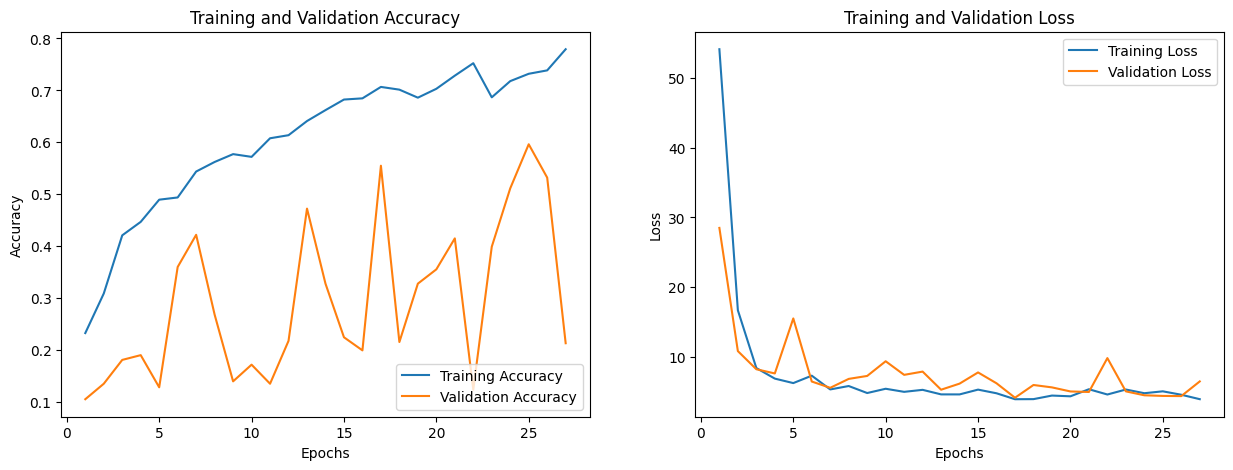

In [18]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(1, len(accuracy) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [19]:
test_loss , test_accuracy = model.evaluate(x_test , y_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5730 - loss: 4.0913


# Employing the Trained Model for Predictions

In [20]:
predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
print("Shape of predictions:", predictions.shape)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Shape of predictions: (871, 20)


# Visualizing Actual vs Predicted Images

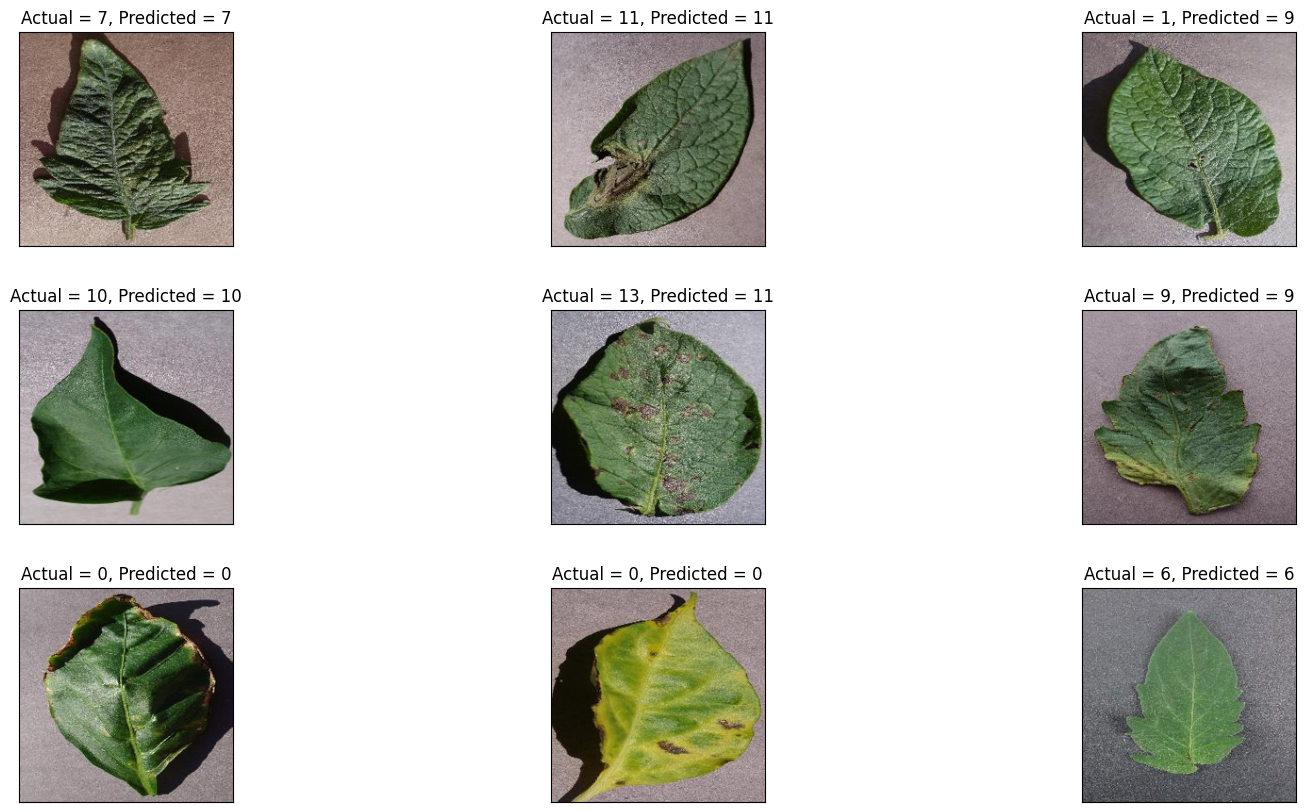

In [21]:
plt.figure(figsize=(19, 10))

for i in range(9):
    r = np.random.randint(0, x_test.shape[0])
    
    plt.subplot(3, 3, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    plt.imshow(x_test[r])
    actual_label = y_test[r]
    predicted_label = np.argmax(predictions[r])
    plt.title('Actual = {}, Predicted = {}'.format(actual_label, predicted_label))
    plt.xticks([]), plt.yticks([])

plt.show()

# Confusion matrix

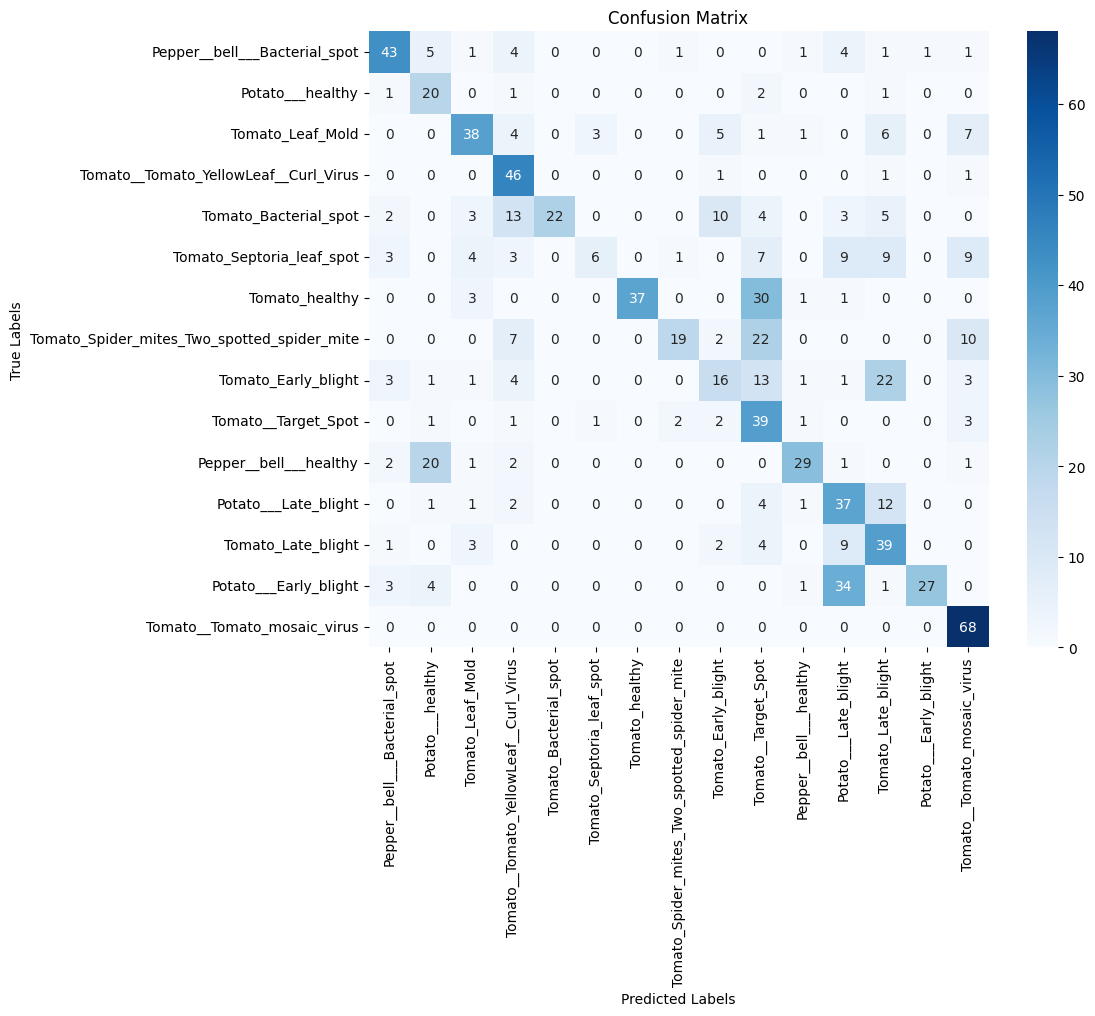

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Model Saving

In [23]:
print("Saving the model...")
# Save the CNN model architecture for plant diseases detection in JSON format
model_json = model.to_json()
with open("../working/cnn_model_plant_diseases.json", "w") as json_file:
    json_file.write(model_json)
print("CNN model architecture for plant diseases detection saved in JSON format.")

# Save the CNN model weights for plant diseases detection in h5 format
model.save_weights("../working/cnn_model_plant_diseases.weights.h5")
print("CNN model weights for plant diseases detection saved.")

Saving the model...
CNN model architecture for plant diseases detection saved in JSON format.
CNN model weights for plant diseases detection saved.
